In [1]:
import random
import pandas as pd
import numpy as np
import ml_utils 

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

## 3950 Assignment 1: Part 2 ##

In [2]:
name = "Darren Lee"

show_eda = False

In [3]:
#Load data
df = pd.read_csv("training.csv")
df = df.drop(columns={"id"})
df.sample(5)

,target,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,var_200
86,1,0.004,0.938,0.339,0.466,0.281,0.692,0.578,0.500,0.179,...,0.951,0.695,0.152,0.146,0.757,0.085,0.809,0.948,0.290,0.921
244,0,0.854,0.994,0.357,0.854,0.794,0.117,0.412,0.673,0.638,...,0.085,0.499,0.122,0.092,0.357,0.974,0.071,0.375,0.368,0.613
128,1,0.784,0.045,0.678,0.468,0.224,0.012,0.169,0.072,0.430,...,0.743,0.007,0.150,0.349,0.561,0.438,0.451,0.921,0.672,0.870
22,0,0.311,0.861,0.040,0.959,0.021,0.815,0.176,0.799,0.001,...,0.628,0.757,0.686,0.390,0.496,0.461,0.900,0.017,0.053,0.727
74,0,0.306,0.753,0.732,0.776,0.892,0.234,0.820,0.166,0.003,...,0.969,0.219,0.840,0.303,0.625,0.467,0.705,0.136,0.095,0.401


### EDA ###

In [4]:
df.shape

(250, 201)

In [5]:
df_eda = ml_utils.edaDF(df, "target")
df_eda.setCat([])
df_eda.setNum(df.columns[1:])

In [6]:
if show_eda:
    df_eda.fullEDA(pairplot=False)

Conclusions from EDA: 
<ul>
    <li> Dataset seems relatively balanced
    <li> Most values appear to be between 0 and 1
    <li> Doesn't seem to be any categorical variables
</ul>

### Create Model ###

Train Test Split

In [7]:
y = np.array(df["target"]).reshape(-1,1)
x = np.array(df.drop(columns={"target"}))

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

Data Prep Pipeline

In [8]:
prep = Pipeline( steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler()) # Don't know the distriutions of all the features so I am using MinMaxScaler()
    ])

Model will use Decision Tree Classifier

In [9]:
clf = DecisionTreeClassifier(random_state=0)

##### First Iteration of the Tree Model #####

In [10]:
pipeline_steps = [
    ('Prep', prep),
    ('DT', clf)
    ]
    
model1 = Pipeline(pipeline_steps)

Depth: 9
Leaves: 22
Training Accuracy: 1.0
Testing Accuracy: 0.5257575757575758 0.5238095238095238


[Text(0.34517045454545453, 0.95, 'var_177 <= 0.113\ngini = 0.499\nsamples = 187\nvalue = [89, 98]\nclass = True'),
 Text(0.13068181818181818, 0.85, 'var_141 <= 0.153\ngini = 0.231\nsamples = 30\nvalue = [4, 26]\nclass = True'),
 Text(0.08522727272727272, 0.75, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]\nclass = False'),
 Text(0.17613636363636365, 0.75, 'var_152 <= 0.941\ngini = 0.071\nsamples = 27\nvalue = [1, 26]\nclass = True'),
 Text(0.13068181818181818, 0.65, 'gini = 0.0\nsamples = 26\nvalue = [0, 26]\nclass = True'),
 Text(0.2215909090909091, 0.65, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = False'),
 Text(0.5596590909090909, 0.85, 'var_199 <= 0.857\ngini = 0.497\nsamples = 157\nvalue = [85, 72]\nclass = False'),
 Text(0.35795454545454547, 0.75, 'var_152 <= 0.848\ngini = 0.477\nsamples = 130\nvalue = [79, 51]\nclass = False'),
 Text(0.3125, 0.65, 'var_133 <= 0.33\ngini = 0.496\nsamples = 112\nvalue = [61, 51]\nclass = False'),
 Text(0.09090909090909091, 0.55, 'var_148 <= 0.098

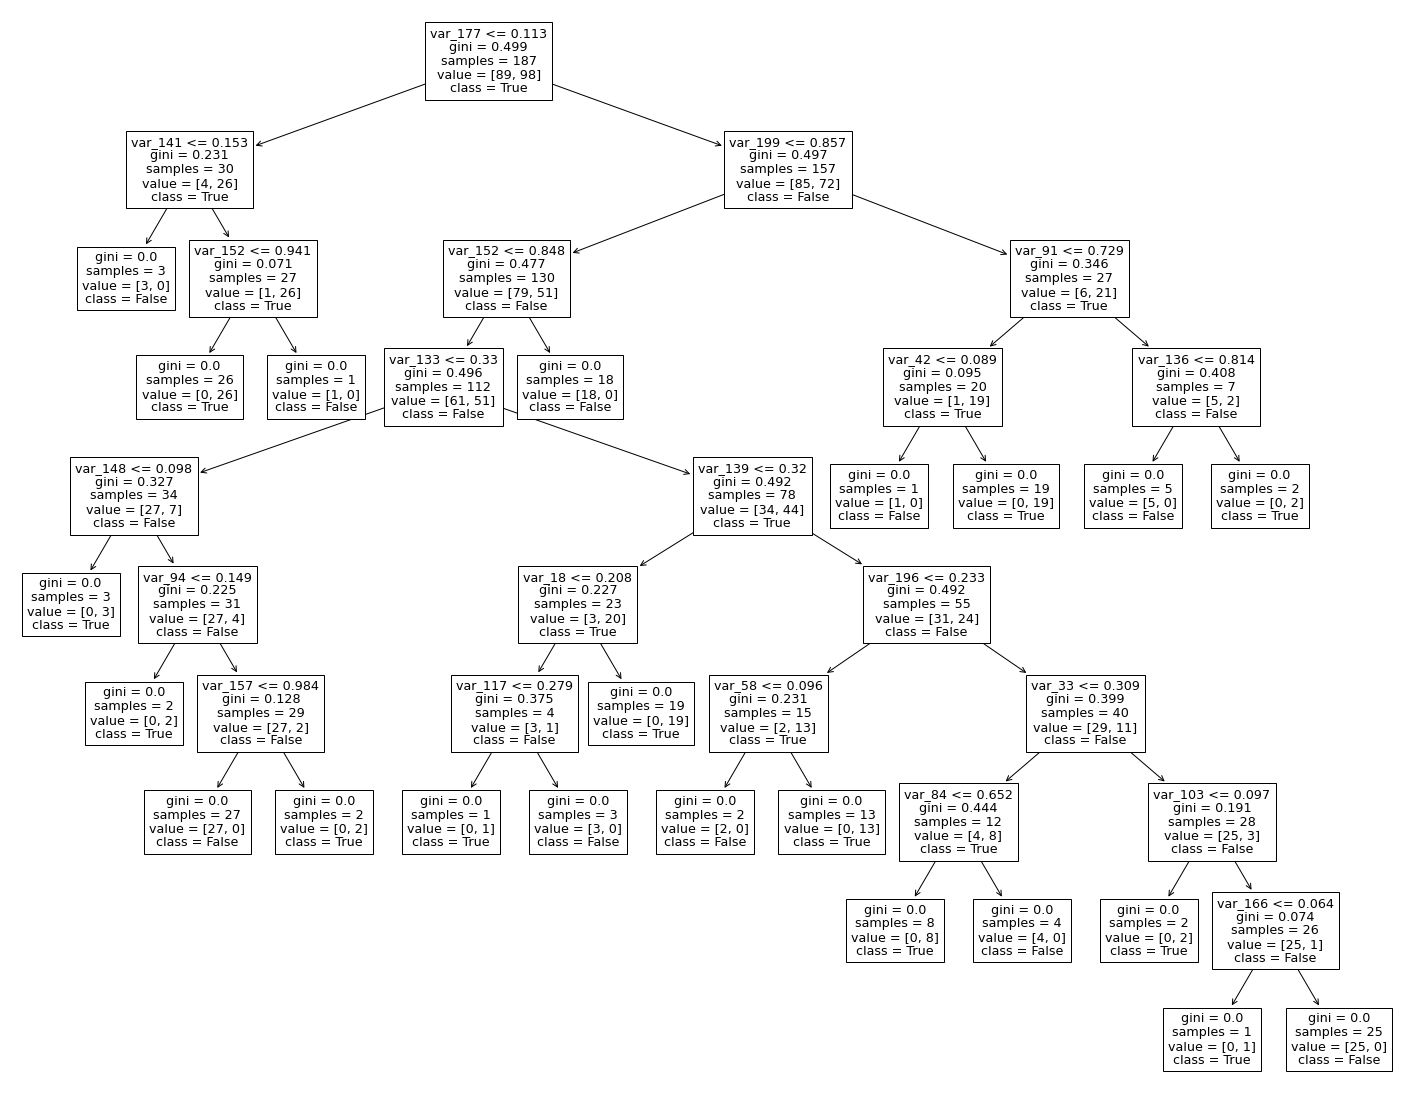

In [11]:
model1.fit(x_train, y_train)
predictions = model1.predict(x_test)

print("Depth:", model1[1].get_depth()) 
print("Leaves:", model1[1].get_n_leaves())
print("Training Accuracy:", model1.score(x_train, y_train))
print("Testing Accuracy:", roc_auc_score(y_test, predictions), accuracy_score(y_test, predictions))
plt.figure(figsize=(25,20))
plot_tree(model1[1], feature_names=df.columns[:-1], class_names=["False","True"])

Tree looks overfitted since many leaves contain small number of samples to that are perfectly split

##### Combatting Overfitting #####
<ul>
<li> Combat by using RandomizedSearchCV to figure out best combination of tree hyperparameters.
</ul>

In [12]:
tree_para = {
    'DT__max_depth':[i for i in range(2, 11)],
    'DT__min_samples_split':[i for i in range(2,11)],
    'DT__min_samples_leaf':[i for i in range(5,11)],
    'DT__max_leaf_nodes': [i for i in range(2, 31)],
    'DT__criterion':["gini", "entropy"]
    }
best = RandomizedSearchCV(estimator=model1, param_distributions=tree_para, cv=5, n_jobs=-1, n_iter=1000)
best.fit(x_train, y_train)
predictions2 = best.predict(x_test)

print(best.best_estimator_[1])
print("Training Accuracy:", best.score(x_train, y_train))
print("Testing Accuracy:", roc_auc_score(y_test, predictions2), accuracy_score(y_test, predictions2))

DecisionTreeClassifier(criterion='entropy', max_depth=8, max_leaf_nodes=7,
                       min_samples_leaf=10, min_samples_split=9,
                       random_state=0)
Training Accuracy: 0.7540106951871658
Testing Accuracy: 0.5454545454545455 0.5396825396825397


Sometimes the model with hyperparameter tuning acheives better accuracy than the first model that does not have hyperparameter tuning. However, sometimes the opposite is true. This is likely due to variability in the Train Test Split as well as the RandomizedSearchCV and the Decision Tree Classifier

Here is a plot of a the tree with hyperparameter tuning using RandomizedSearchCV:

[Text(0.625, 0.9285714285714286, 'var_177 <= 0.113\nentropy = 0.998\nsamples = 187\nvalue = [89, 98]\nclass = True'),
 Text(0.5, 0.7857142857142857, 'entropy = 0.567\nsamples = 30\nvalue = [4, 26]\nclass = True'),
 Text(0.75, 0.7857142857142857, 'var_42 <= 0.919\nentropy = 0.995\nsamples = 157\nvalue = [85, 72]\nclass = False'),
 Text(0.625, 0.6428571428571429, 'var_49 <= 0.934\nentropy = 1.0\nsamples = 145\nvalue = [73, 72]\nclass = False'),
 Text(0.5, 0.5, 'var_199 <= 0.855\nentropy = 0.997\nsamples = 135\nvalue = [63, 72]\nclass = True'),
 Text(0.375, 0.35714285714285715, 'var_152 <= 0.848\nentropy = 0.996\nsamples = 110\nvalue = [59, 51]\nclass = False'),
 Text(0.25, 0.21428571428571427, 'var_122 <= 0.125\nentropy = 0.997\nsamples = 96\nvalue = [45, 51]\nclass = True'),
 Text(0.125, 0.07142857142857142, 'entropy = 0.353\nsamples = 15\nvalue = [1, 14]\nclass = True'),
 Text(0.375, 0.07142857142857142, 'entropy = 0.995\nsamples = 81\nvalue = [44, 37]\nclass = False'),
 Text(0.5, 0.21

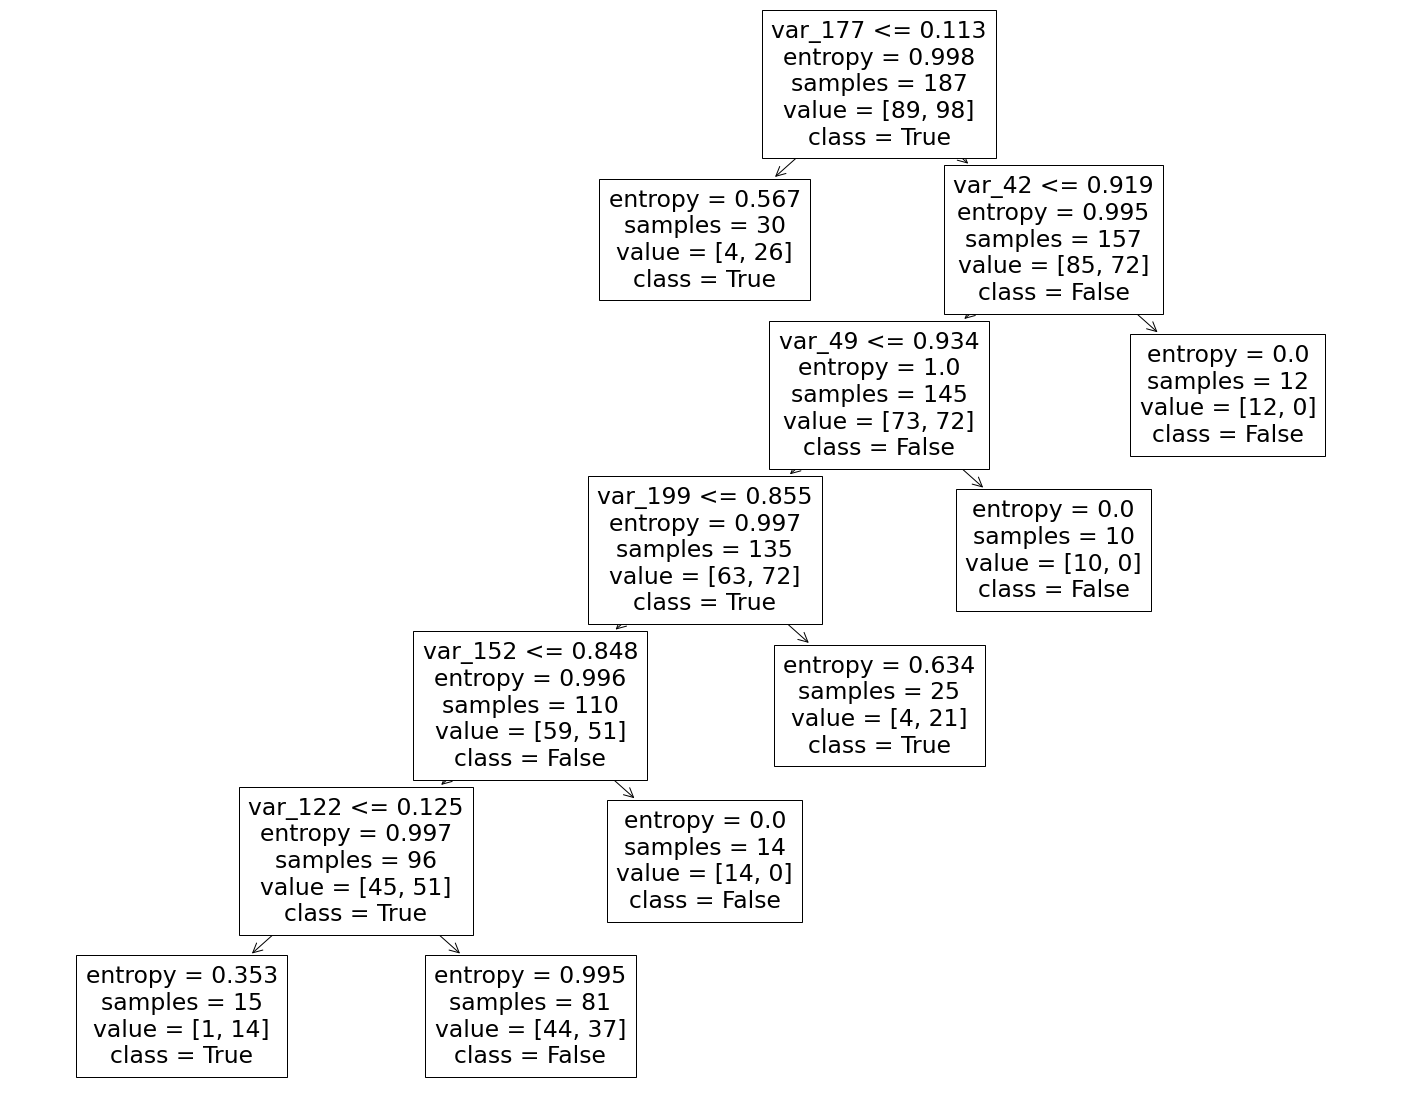

In [13]:
plt.figure(figsize=(25,20))
plot_tree(best.best_estimator_[1], feature_names=df.columns[:-1], class_names=["False","True"])

### Testing

In [14]:
# Load Test Data
test_df = pd.read_csv("testing.csv")
test_df = test_df.drop(columns={"id"})
# Create tests and score
test_y = np.array(test_df["target"]).reshape(-1,1)
test_X = np.array(test_df.drop(columns={"target"}))

preds = best.predict(test_X)

roc_score = roc_auc_score(test_y, preds)
acc_score = accuracy_score(test_y, preds)

print(roc_score)
print(acc_score)
print(name, np.mean([roc_score, acc_score]))


0.7064276092116236
0.7
Darren Lee 0.7032138046058118


### What Accuracy Changes Were Used

Please list here what you did to try to increase accuracy and/or limit overfitting:
<ul>
<li> Implement hyperarameter tuning into the model by using RandomizedSearchCV to test a wider range of parameters using less resources. (depth, minimum samples needed to create leaf, minimum samples required to split a node, gini/entropy)
<li> Run multiple tests to figure out reasonable list of parameters.
<li> Implement scaling in pipeline
</ul>